In [1]:
'''Lab | Customer Analysis Final Round. Since we are doing collaborating work with our group mates, my comments
are for my teammates'''#######################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import math
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import stats

## 01 - Problem (case study): Data Description + Goal ##

In [346]:
# Predicting the customer life time value based on the data provided (marketing_customer_analysis.csv)

## 02 - Getting Data: Read the .csv file ##

In [2]:
file = pd.read_csv('marketing_customer_analysis.csv')

In [3]:
#data.head()
data = file.drop(['Customer'], axis = 1)


In [4]:
data.shape

(9134, 23)

## 03 - Cleaning/Wrangling/EDA: ##

### Change headers names #

In [5]:
data.columns = [val.lower().replace(' ','_') for val in data.columns]
data.columns

Index(['state', 'customer_lifetime_value', 'response', 'coverage', 'education',
       'effective_to_date', 'employmentstatus', 'gender', 'income',
       'location_code', 'marital_status', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies', 'policy_type',
       'policy', 'renew_offer_type', 'sales_channel', 'total_claim_amount',
       'vehicle_class', 'vehicle_size'],
      dtype='object')

In [6]:
data = data.drop_duplicates()
data.head()
data.shape
#data.dtypes


(8971, 23)

In [7]:
#catagorical columns values appeared excellent.
X_Cat = data.select_dtypes(include=np.object)
'''for val in X_Cat.columns:
    print(X_Cat[val].unique())'''


'for val in X_Cat.columns:\n    print(X_Cat[val].unique())'

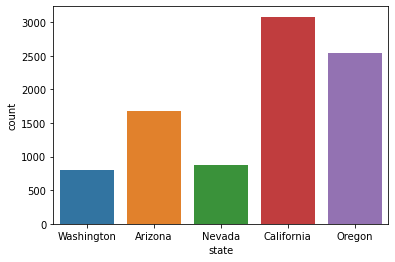

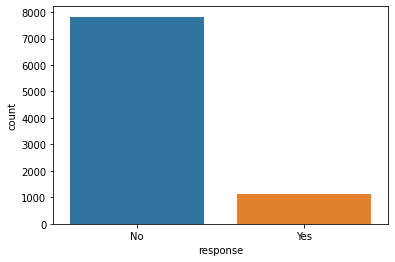

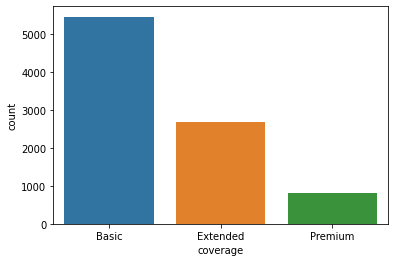

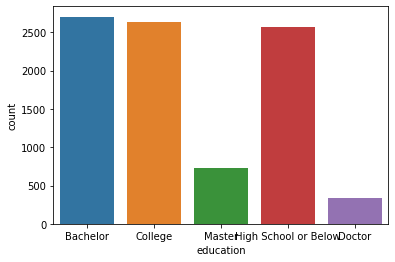

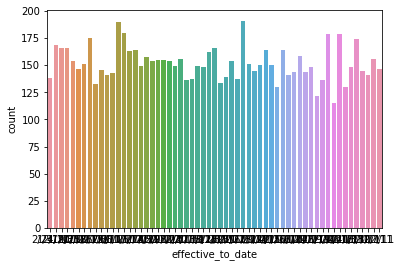

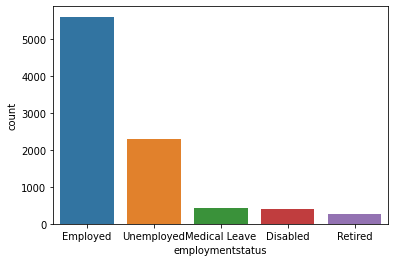

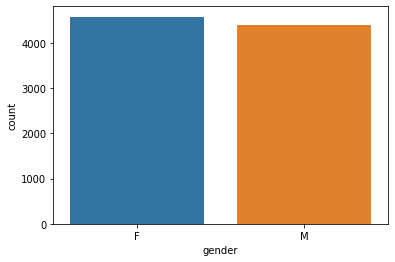

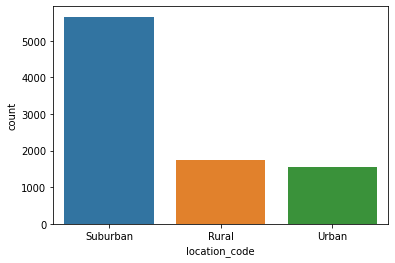

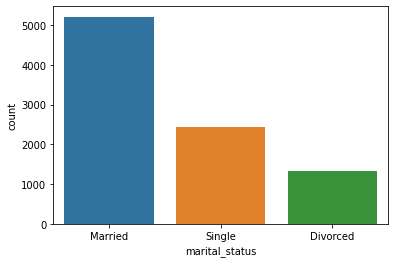

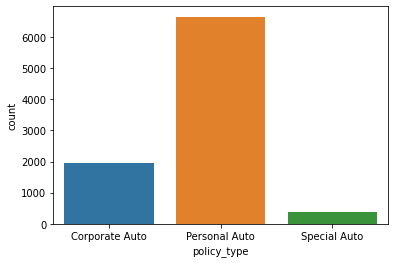

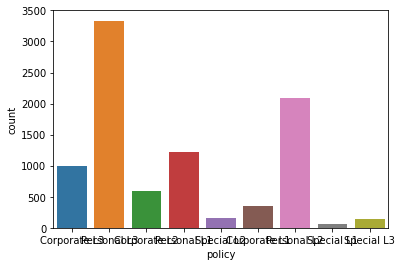

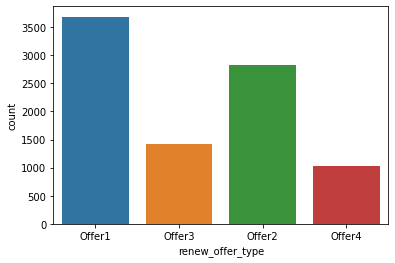

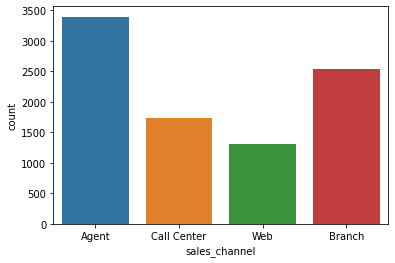

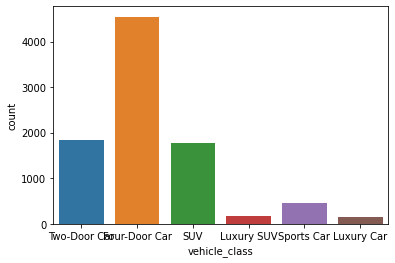

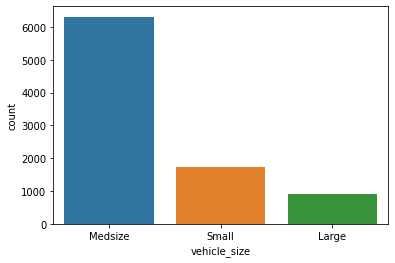

In [8]:
for val in X_Cat.columns:  
    sns.countplot(x=data[val])
    plt.show()

In [9]:
data['effective_to_date'] = pd.to_datetime(data['effective_to_date'], errors='coerce')

### Deal with NaN values #

In [359]:
#data.isna().sum()
# since there are no NaN values, we dont have to replace / deal with NaN's

### Numerical Features #

In [10]:
X_num = data.select_dtypes(include=np.number)

### Exploration #

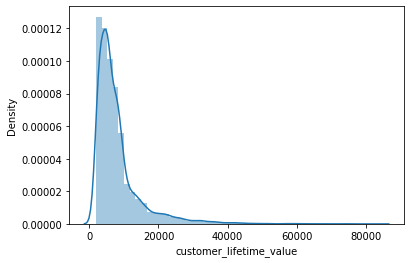

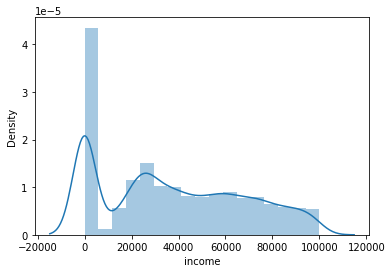

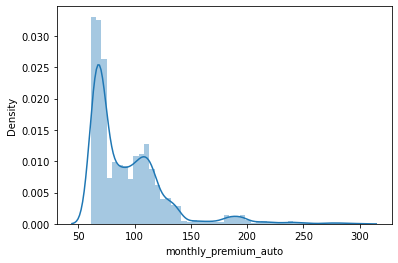

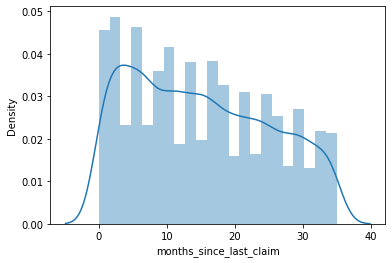

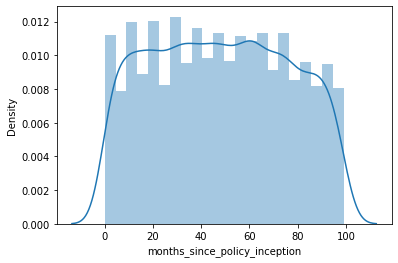

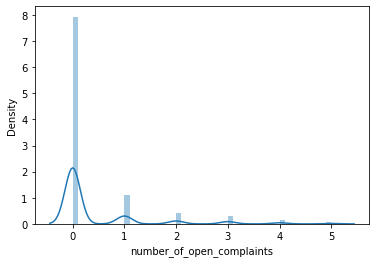

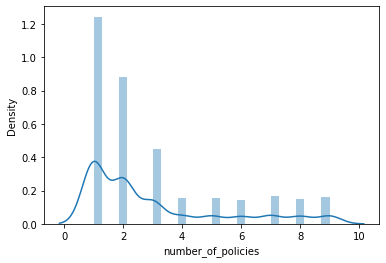

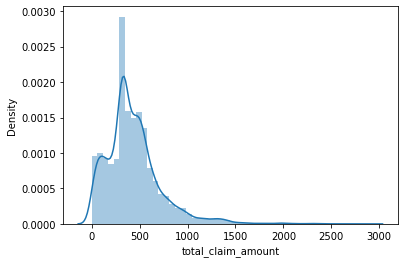

'issue is the income column, has many zero values\nthe rest of columns are ready for boxcox implementation \nand after that we look for outliers through box plot and deal with them '

In [11]:
for val in X_num.columns:
    sns.distplot(X_num[val])
    plt.show()
'''issue is the income column, has many zero values
the rest of columns are ready for boxcox implementation 
and after that we look for outliers through box plot and deal with them ''' 

In [250]:
#data.describe()

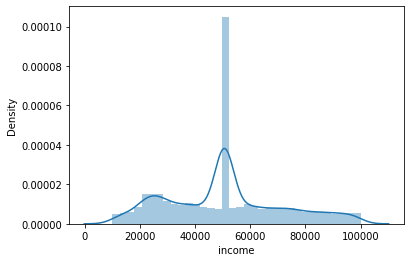

'this will be trimmed when we analyse outliers, definitely it is a bias we have added\nbut it is better than considering 0 in income column'

In [12]:
#replacing 0 vlues in income column with the mean excluding 0 vaues indexes
#data['income'] = np.where(data['income']<=0,0,data['income'])
# now calculate mean of the new column , exluding zeros in the count 
mean = np.sum(X_num['income'])/len(X_num[X_num['income']>0])
X_num['income'] = X_num['income'].replace(0,mean)
sns.distplot(X_num['income'])
plt.show()
'''this will be trimmed when we analyse outliers, definitely it is a bias we have added
but it is better than considering 0 in income column'''

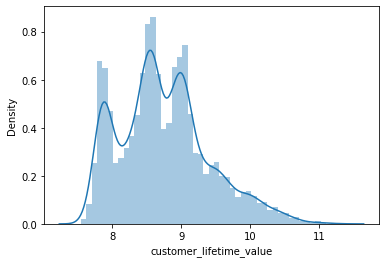

In [13]:
#customer life time value column right skewed, lets see what happen if I apply log function 
def my_log(x):
    if x == 0:
        return x
    else:
        return np.log(x)
X_num['customer_lifetime_value'] = list(map(my_log,X_num['customer_lifetime_value']))
sns.distplot(X_num['customer_lifetime_value'])
plt.show()
from scipy import stats

# looks better to me (may be some other transformation will work better)

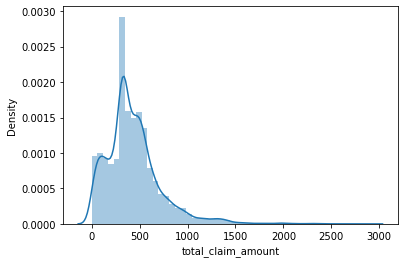

"'didn'work!!!! lets go for boxcox plot for each numerical \ncolumn in order to achieve the assumption of data being normally distributed. Box plot works on \npositive values. After applying the my_log function I see negative values in total_claim_amount column so we\nshouldn't apply my_log function here"

In [14]:
# for column total claim amunt I have applied  the same my_log function
#X_num['total_claim_amount'] = list(map(my_log,X_num['total_claim_amount']))
sns.distplot(X_num['total_claim_amount'])
plt.show()
''''didn'work!!!! lets go for boxcox plot for each numerical 
column in order to achieve the assumption of data being normally distributed. Box plot works on 
positive values. After applying the my_log function I see negative values in total_claim_amount column so we
shouldn't apply my_log function here'''

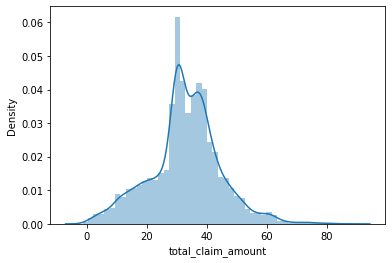

0.4712498984698542


In [15]:
#for val in X_num.columns:
#for val in X_num:
X_num['total_claim_amount'], lmbda = stats.boxcox(X_num['total_claim_amount'])  
sns.distplot(X_num['total_claim_amount'])
plt.show()
print(lmbda)

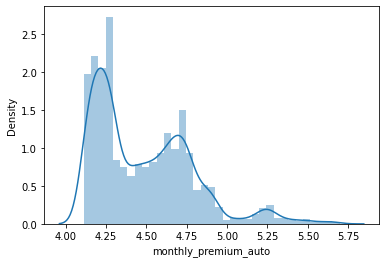

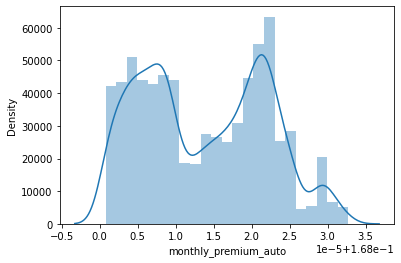

-5.951031539710685


In [16]:
X_num['monthly_premium_auto'] = list(map(my_log,X_num['monthly_premium_auto']))
sns.distplot(X_num['monthly_premium_auto'])
plt.show()
X_num['monthly_premium_auto'], lmbda = stats.boxcox(X_num['monthly_premium_auto'])  
sns.distplot(X_num['monthly_premium_auto'])
plt.show()
print(lmbda)
#much better, we will review them after removing outliers

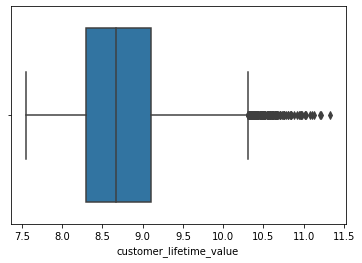

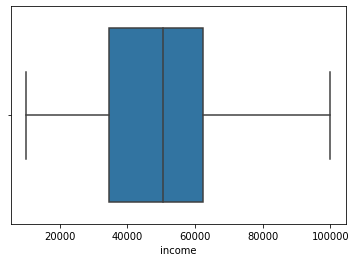

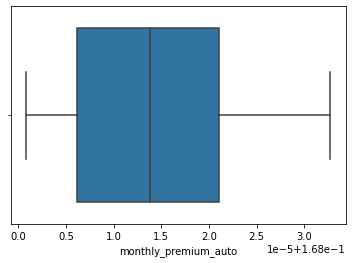

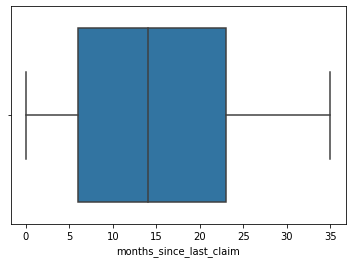

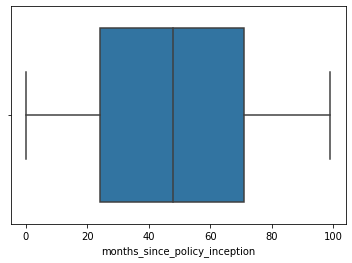

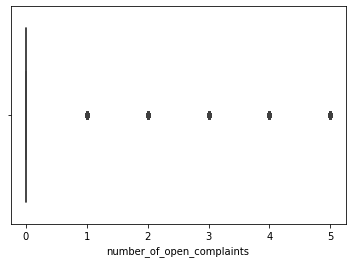

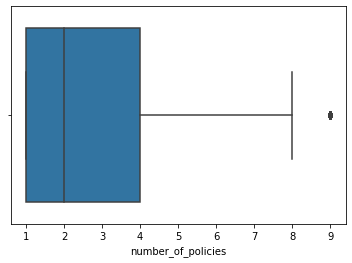

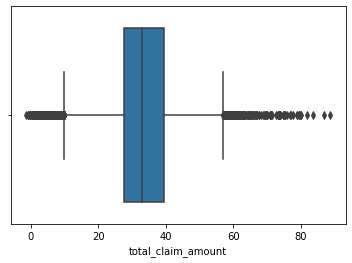

In [17]:

#looking for outliers in numerical data
for val in X_num.columns:
    sns.boxplot(X_num[val])
    plt.show()

In [18]:
# I found on internet another approach to remove outliers using Z_score... 
z = np.abs(stats.zscore(X_num))
threshold = 3
#print(np.where(z > 3))

In [19]:
df = pd.DataFrame(z)
df = df[(z < 3).all(axis=1)]

df.columns = X_num.columns
print(df.shape)
print(X_num.shape)
#X_num.shape

(8697, 8)
(8971, 8)


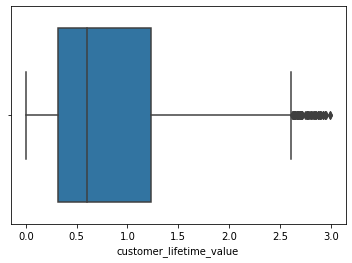

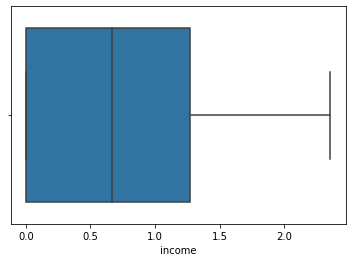

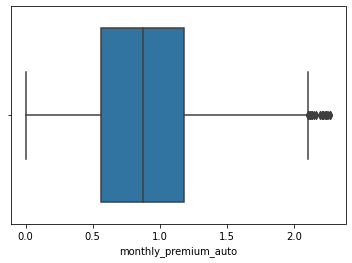

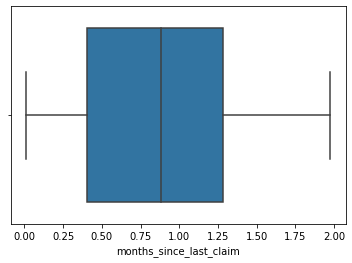

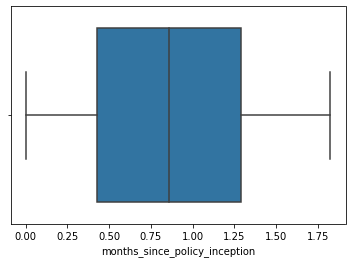

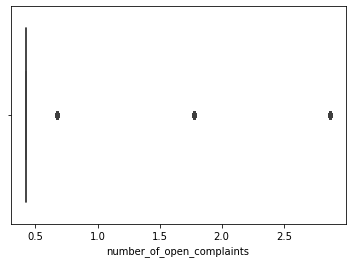

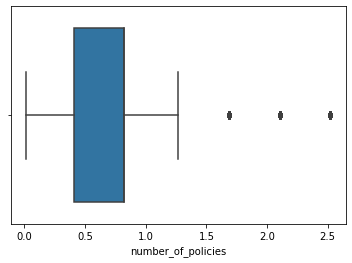

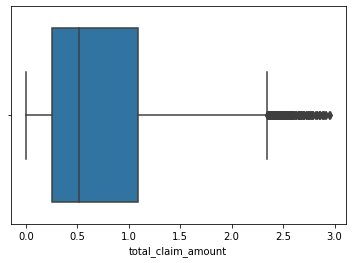

In [20]:
# The above approach did remove some outliers, lets see if we have get rid of them by plotting box_plot 
for val in df.columns:
    sns.boxplot(df[val])
    plt.show()
#still exist lets check with iqr method

In [55]:
#IQR with factor 3
df_iqr = X_num
Q1 = df_iqr.quantile(0.25)
Q3 = df_iqr.quantile(0.75)
IQR = Q3 - Q1
#print(IQR)

df_iqr = df_iqr[~((df_iqr < (Q1 - 3 * IQR)) |(df_iqr > (Q3 + 3 * IQR))).any(axis=1)]
print(X_num.shape) # original data
print(df.shape) #z_score approach for removing outliers
print(df_iqr.shape)

(8971, 8)
(8546, 8)
(6811, 8)


In [56]:
#IQR with factor 1.5
df_iqr1 = X_num
Q_1 = df_iqr1.quantile(0.25)
Q_3 = df_iqr1.quantile(0.75)
IQR = Q3 - Q1
#print(IQR)

df_iqr1 = df_iqr1[~((df_iqr1 < (Q_1 - 1.5 * IQR)) |(df_iqr1 > (Q_3 + 1.5 * IQR))).any(axis=1)]
print(X_num.shape) # original data
print(df.shape) #z_score approach for removing outliers
print(df_iqr.shape) # with 1.5
print(df_iqr1.shape) # with 3
# loosing more data with factor 1.5 

(8971, 8)
(8546, 8)
(6811, 8)
(5790, 8)


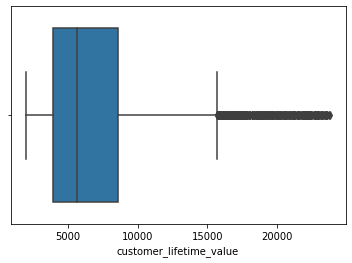

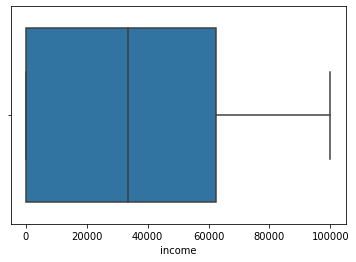

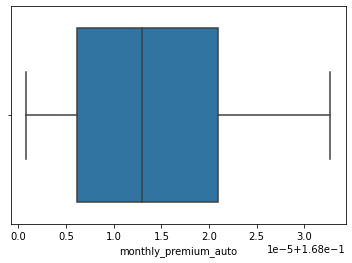

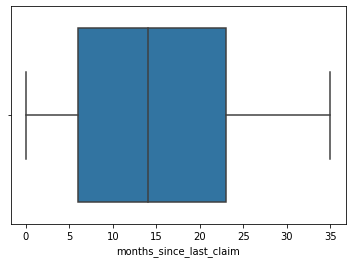

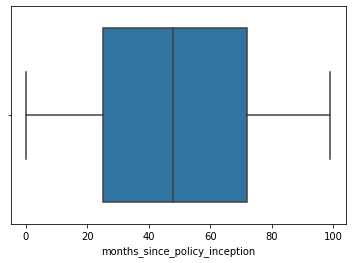

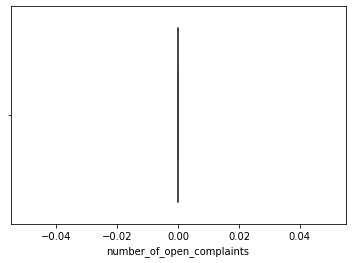

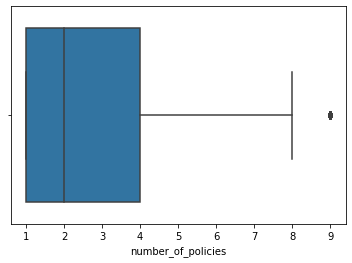

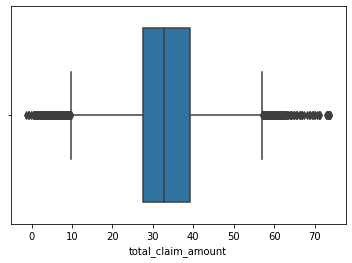

In [57]:
# lets check the outliers with IQR 3 
for val in df_iqr.columns:
    sns.boxplot(df_iqr[val])
    plt.show()

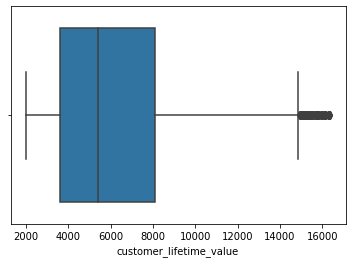

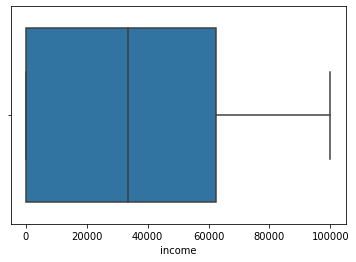

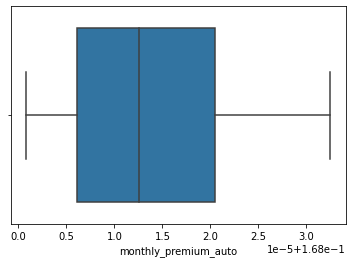

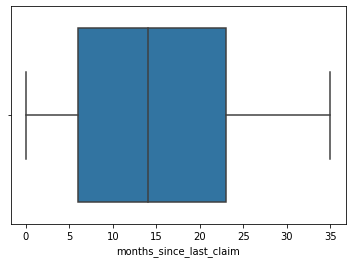

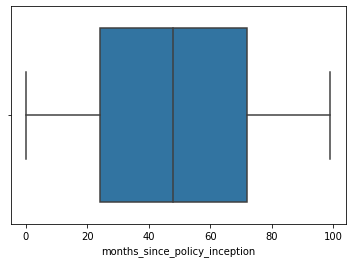

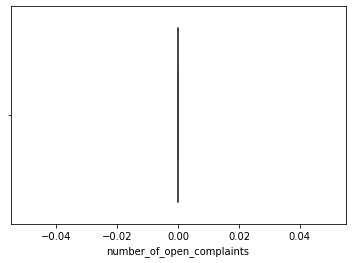

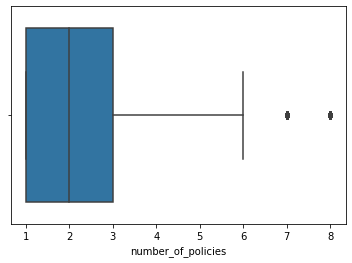

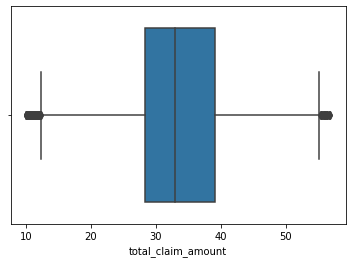

In [58]:
# lets check the outliers with IQR factor 1.5
for val in df_iqr1.columns:
    sns.boxplot(df_iqr1[val])
    plt.show()
# pretty much there after loosing approximately 3000 observations !!!!  

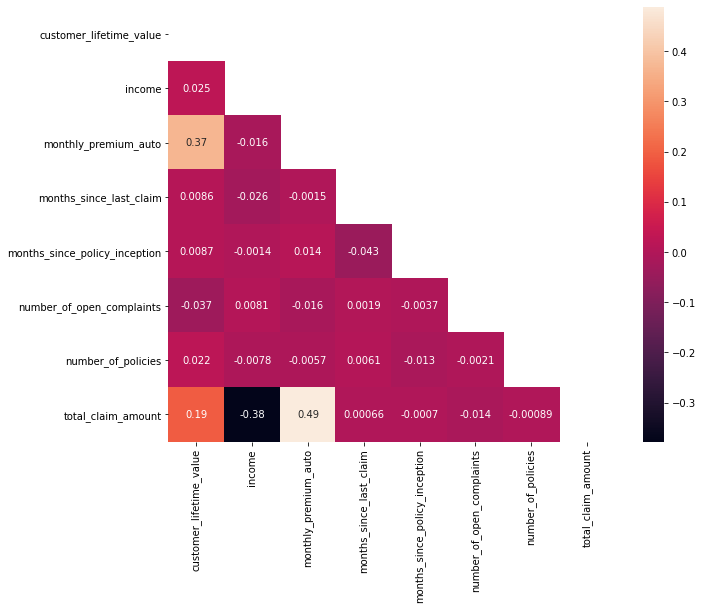

In [59]:
#heat map with original numerical data
correlations_matrix = X_num.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

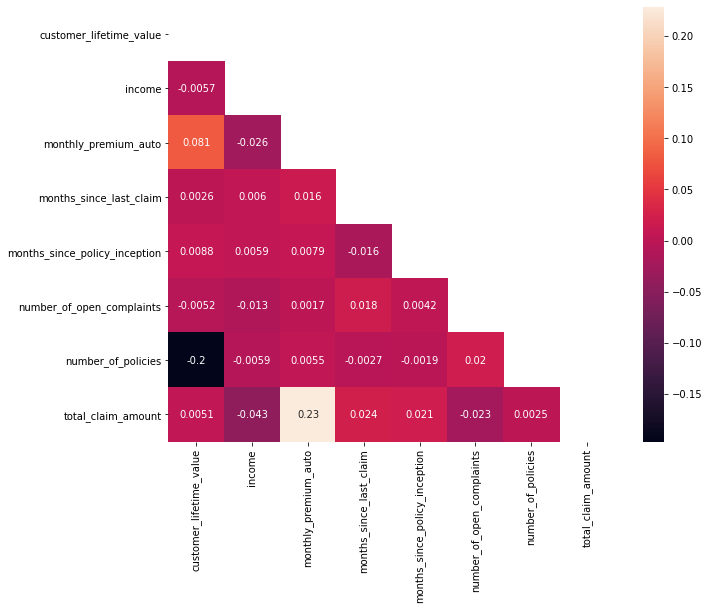

In [60]:
# heat map with z_score outliers removing method
correlations_matrix = df.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

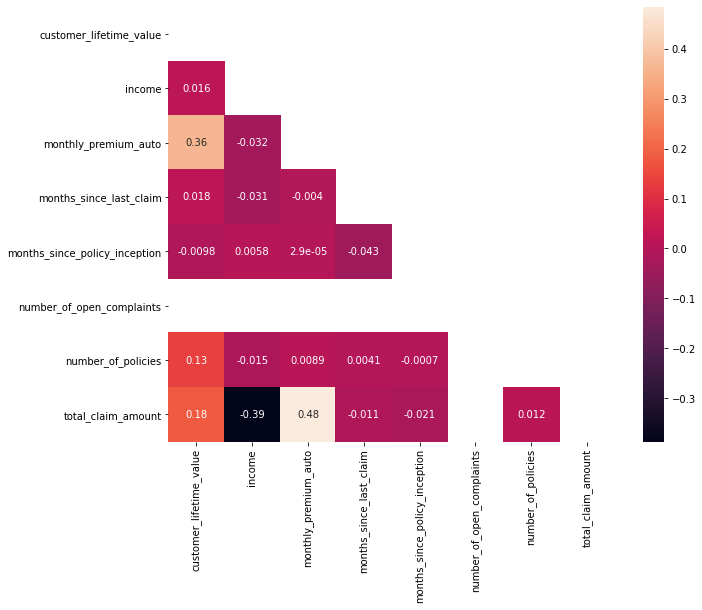

In [61]:
# heat map of iqr method with factor 3
correlations_matrix = df_iqr.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

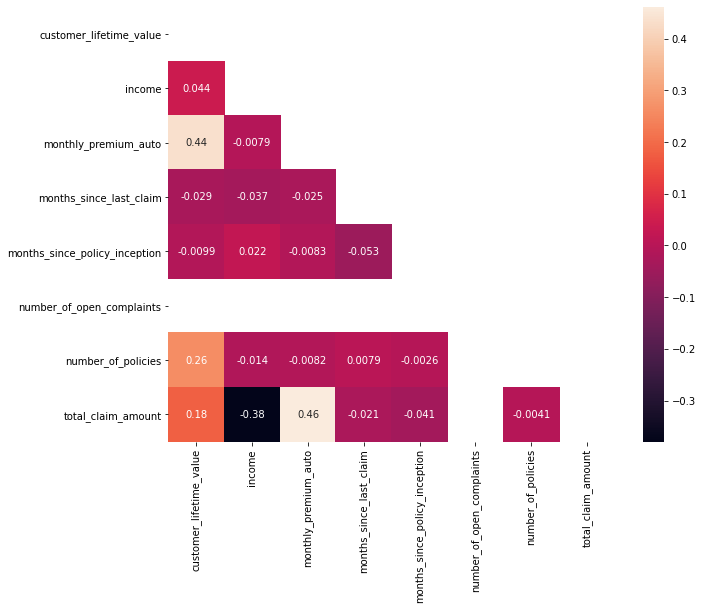

"In most practical circumstances an outlier decreases the value of a correlation coefficient and weakens the \nregression relationship, but it's also possible that in some circumstances an \noutlier may increase a correlation value and improve regression. Searched on google find it useful. Its better not\nto drop any column "

In [62]:
# heat map of iqr method with factor 1.5
correlations_matrix = df_iqr1.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()
'''In most practical circumstances an outlier decreases the value of a correlation coefficient and weakens the 
regression relationship, but it's also possible that in some circumstances an 
outlier may increase a correlation value and improve regression. Searched on google find it useful. Its better not
to drop any column ''' 

In [63]:
#linear regression model preparation on orginal data
Y = X_num['customer_lifetime_value']
X = X_num.drop(['customer_lifetime_value'], axis=1)

### Normalization # 

In [64]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(X)
x_normalized = transformer.transform(X)
#print(x_normalized.shape)

### Encoding Categorical Data #

In [65]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='error', drop='first').fit(X_Cat)
encoded = encoder.transform(X_Cat).toarray()

### Splitting into train set and test set #

In [66]:
X = np.concatenate((x_normalized, encoded), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=100)

# 05 - Modeling ##

### Apply model #

In [67]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)
predictions  = model.predict(X_test)

# 06 - Model Validation ##

### R2 #

In [68]:
r2 = r2_score(y_test, predictions)
print(r2)

0.11368628402613579


### MSE #

In [69]:
mse = mean_squared_error(y_test, predictions)
print(mse)


39743928.933937036


### RMSE #

In [70]:
rmse = math.sqrt(mse)
print(rmse)

6304.278621217263
